# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data `training.csv` to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [305]:
!pip install nltk


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [306]:
!pip install vaderSentiment


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [280]:
#Required Imports

import nltk
import string
import re
import csv    # csv reader
import numpy as np
from nltk.stem import WordNetLemmatizer
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
%matplotlib inline
pd.options.display.max_colwidth=500
from nltk import pos_tag
from nltk import RegexpParser
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn import metrics
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.util import ngrams
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pranj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pranj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pranj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pranj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pranj\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [364]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
display(all_train_data)
display(test_data)


,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"You'll be alright Kevin. They're gonna cut you out. It's going to be alright. Come on, just talk to me. Just, just talk to me. Call me names- let me know you're still here with me.",FEMALE
1,1350,7,DESERTED CAR PARK EXT NIGHT,OTHER,...I've got pins and needles in my fingers.,MALE
2,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,That's the cold.,FEMALE
3,1350,7,DESERTED CAR PARK EXT NIGHT,OTHER,Yeah. It's all shutting down.,MALE
4,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,It's just the cold.,FEMALE
...,...,...,...,...,...,...
1762,1398,32,GEORGE STREET EXT NIGHT,JANE,I know. Now Ian come on. Everything's going to be alright. It is. It's going to be alright.,FEMALE
1763,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,TANYA,Night night baby. I love you.,FEMALE
1764,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,OTHER,Love you too.,FEMALE
1765,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,TANYA,"Let's get that under your ankle shall we. Careful, alright? Night night darling. Love you.",FEMALE


In [365]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
#print(epsiode_scene_column)

all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)


1394
1254 140


In [366]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [367]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [368]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [369]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character

train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


In [370]:
def normalizing_lamatizing(tokens):
    """
    This method performs multiple data cleaning steps, such as removing stopwords, 
    removing punctuation, and performs stemming(Stemming means reducing inflection in words to their root forms).
    : return: a list of tokens after cleaning.
    """
    # removing stopwords
    tokens_without_sw = [w for w in tokens if not w.lower() in stopwords.words('english')]
    tokes_without_pucn = [w.lower() for w in tokens_without_sw if w.isalpha()]
    sb = SnowballStemmer('english')
    tokens_after_stem = [sb.stem(w) for w in tokes_without_pucn]
    return tokens_after_stem

In [371]:
def add_ngrams(tokens, n):
    """
    This method can convert tokens to given add ngrams.
    : param tokens: Input list of words/tokens
    : param n: number of ngram need to use.
    : return: return a list of tokens based on ngram size.
    """
    return list(ngrams(tokens, n))

In [372]:
def using_regex(text):
    """
    This method uses a Regex to separates punctuation at beginning and ends of strings. 
    :param text: a string of one statement
    : return: tokens: list of words in text
    """
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings
    text = re.sub('\d+', 'NUMBER',text)
    tokens = text.split()
    return tokens

In [373]:
def remove_characters_after_tokenization(tokens):
    """
    Removes characters from tokens. Preserving critical social media/twitter characters @ and #
    : param tokens: Input list of words/tokens
    : return: tokens: list of words in text
    """
    # note preserving critical social media/twitter characters @ and #
    p = '[{}]'.format(re.escape(string.punctuation)+'\…').replace("@", "").replace("\#", "")
    pattern = re.compile(p)
    filtered_tokens = [f for f in filter(None, [pattern.sub('', token) for token in tokens])]
    return filtered_tokens

def convert_to_lowercase(tokens):
    """
    Converts the tokens to lowercase
    : param tokens: Input list of words/tokens
    : return: tokens: list of words in text
    """
    return [token.lower() for token in tokens if token.isalpha()]

def remove_stopwords(tokens):
    """
    Removing the stopwords provided by NLTK.
    : param tokens: Input list of words/tokens
    : return: tokens: list of words in text
    """
    stopword_list = nltk.corpus.stopwords.words('english')
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens


In [374]:
def apply_lemmatization(tokens, wnl=WordNetLemmatizer()):  
    """
    Applying the lamitization using WordNetLemmatizer
    : param tokens: Input list of words/tokens
    : return: tokens: list of words in text
    """
    return [wnl.lemmatize(token) for token in tokens]

In [375]:
def pre_process(character_text):
    """
    Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization, removing punctuation, removing stop words, lemitization
    and other techniques.    
    :character_text:: a string with all of one character's lines
    :return: tokens: list of words in text
    """
    tokens_reg = using_regex(character_text)
    tokens_rm_chr = remove_characters_after_tokenization(tokens_reg)
    tokens_lc = convert_to_lowercase(tokens_rm_chr)
    tokens_rm_stopwords = remove_stopwords(tokens_lc)
    tokens = apply_lemmatization(tokens_rm_stopwords)
    return tokens

In [376]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [377]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """
    Converts a list of pre-processed tokens and extra features to a Dictionary as a function of the tokens.
    1. Using multiple techniques such as, sentiment analysis (to get the positive, negative or neutral sentiments from sentenses)
    2. Using POS taaging for every word in character document.
    3. Trying multiple ngrams such as Unigram, Bigram and Trigram.
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    #Vader Semintent Analysis
    sentiment = SentimentIntensityAnalyzer()
    s1 = []
    s2 = []
    new_char_doc_with_sentiment = []
    for data in character_doc:
        if data != 'eol':
            s1.append(data)
        else:
            s1.append('eol')
            s2.append(s1)
            s1 = []
        
    for sentence in s2:
        new_sen = " ".join(sentence)
        score = sentiment.polarity_scores(new_sen)
        if score['pos'] > score['neg']:
            new_sen += ' positive'
        elif score['neg'] > score['pos']:
            new_sen += ' negative'
        else:
            new_sen += ' neutral'
        new_char_doc_with_sentiment.append(new_sen)
        
    #POS tag
    sen_with_pos_tag = []
    for val in new_char_doc_with_sentiment:
        tokens_tag = pos_tag(val.split())
        pos_tagged_docs = []
        for val in tokens_tag:
            pos_tagged_docs.append(val[0] + '/' + val[1])
        sen_with_pos_tag.append(pos_tagged_docs)
    v = sum(sen_with_pos_tag, [])

    
    #Unigram
    ngram_data = list(ngrams(v, 1))
    counts = Counter(ngram_data) 
    counts = dict(counts)
    
#     #Bigram
#     ngram_data = list(ngrams(v, 2))
#     counts = Counter(ngram_data) 
#     counts = dict(counts)
    
#     #Trigram
#     ngram_data = list(ngrams(v, 3))
#     counts = Counter(ngram_data)
#     counts = dict(counts)
    
    
#     counts = Counter(character_doc)  # for now a simple count
#     counts = dict(counts)

    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return counts  

In [378]:
from sklearn.feature_extraction.text import TfidfTransformer
corpusVectorizer = DictVectorizer() # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
training_feature_matrix

<16x5305 sparse matrix of type '<class 'numpy.float64'>'
	with 13354 stored elements in Compressed Sparse Row format>

In [379]:
training_feature_matrix

<16x5305 sparse matrix of type '<class 'numpy.float64'>'
	with 13354 stored elements in Compressed Sparse Row format>

In [380]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062


In [381]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [382]:
val_feature_matrix

<16x5305 sparse matrix of type '<class 'numpy.float64'>'
	with 2122 stored elements in Compressed Sparse Row format>

In [383]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [384]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [302]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [40]:
# mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
# print(f"Mean Rank and mean cosine similarity with Tokenization: {mean_rank, mean_cosine_simliarity}")

mean rank 7.3125
mean cosine similarity 0.9860094066863742
1 correct out of 16 / accuracy: 0.0625
Mean Rank and mean cosine similarity with Tokenization: (7.3125, 0.9860094066863742)


mean rank 7.3125

mean cosine similarity 0.9860094066863742

1 correct out of 16 / accuracy: 0.0625

Mean Rank and mean cosine similarity with Tokenization: (7.3125, 0.9860094066863742)

In [32]:
# mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
# print(f"Mean Rank and mean cosine similarity with lower case: {mean_rank, mean_cosine_simliarity}")

mean rank 5.4375
mean cosine similarity 0.9951208062467722
4 correct out of 16 / accuracy: 0.25
Mean Rank and mean cosine similarity with lower case: (5.4375, 0.9951208062467722)


mean rank 5.4375

mean cosine similarity 0.9951208062467722

4 correct out of 16 / accuracy: 0.25

Mean Rank and mean cosine similarity with lower case: (5.4375, 0.9951208062467722)

In [49]:
# mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
# print(f"Mean Rank and mean cosine similarity with Removing stopwords: {mean_rank, mean_cosine_simliarity}")

mean rank 4.5
mean cosine similarity 0.9971964461936824
3 correct out of 16 / accuracy: 0.1875
Mean Rank and mean cosine similarity with Removing stopwords: (4.5, 0.9971964461936824)


mean rank 4.5

mean cosine similarity 0.9971964461936824

3 correct out of 16 / accuracy: 0.1875

Mean Rank and mean cosine similarity with Removing stopwords: (4.5, 0.9971964461936824)

In [59]:
# mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
# print(f"Mean Rank and mean cosine similarity after applying Lammatization: {mean_rank, mean_cosine_simliarity}")

mean rank 4.6875
mean cosine similarity 0.996453490972118
5 correct out of 16 / accuracy: 0.3125
Mean Rank and mean cosine similarity after applying Lammatization: (4.6875, 0.996453490972118)


mean rank 4.6875

mean cosine similarity 0.996453490972118

5 correct out of 16 / accuracy: 0.3125

Mean Rank and mean cosine similarity after applying Lammatization: (4.6875, 0.996453490972118)

In [385]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
print(f"Mean Rank and mean cosine similarity by applying all selected preprocessing and applying Sentiment Analysis, Unigram and POS tagging: {mean_rank, mean_cosine_simliarity}")

mean rank 3.375
mean cosine similarity 0.8929213375666305
10 correct out of 16 / accuracy: 0.625
Mean Rank and mean cosine similarity by applying all selected preprocessing and applying Sentiment Analysis, Unigram and POS tagging: (3.375, 0.8929213375666305)


mean rank 3.375

mean cosine similarity 0.8929213375666305

10 correct out of 16 / accuracy: 0.625

Mean Rank and mean cosine similarity by applying all selected preprocessing and applying Sentiment Analysis, Unigram and POS tagging: (3.375, 0.8929213375666305)

In [97]:
# mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
# print(f"Mean Rank and mean cosine similarity by applying all selected preprocessing and applying Sentiment Analysis, Bigram and POS tagging: {mean_rank, mean_cosine_simliarity}")

mean rank 6.125
mean cosine similarity 0.753238456052451
4 correct out of 16 / accuracy: 0.25
Mean Rank and mean cosine similarity by applying all selected preprocessing and applying Sentiment Analysis, Bigram and POS tagging: (6.125, 0.753238456052451)



mean rank 6.125

mean cosine similarity 0.753238456052451

4 correct out of 16 / accuracy: 0.25

Mean Rank and mean cosine similarity by applying all selected preprocessing and applying Sentiment Analysis, Bigram and POS tagging: (6.125, 0.753238456052451)

In [104]:
# mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
# print(f"Mean Rank and mean cosine similarity by applying all selected preprocessing and applying Sentiment Analysis, Trigram and POS tagging: {mean_rank, mean_cosine_simliarity}")

mean rank 6.1875
mean cosine similarity 0.12991717707323638
2 correct out of 16 / accuracy: 0.125
Mean Rank and mean cosine similarity by applying all selected preprocessing and applying Sentiment Analysis, Trigram and POS tagging: (6.1875, 0.12991717707323638)


mean rank 6.1875

mean cosine similarity 0.12991717707323638

2 correct out of 16 / accuracy: 0.125

Mean Rank and mean cosine similarity by applying all selected preprocessing and applying Sentiment Analysis, Trigram and POS tagging: (6.1875, 0.12991717707323638)

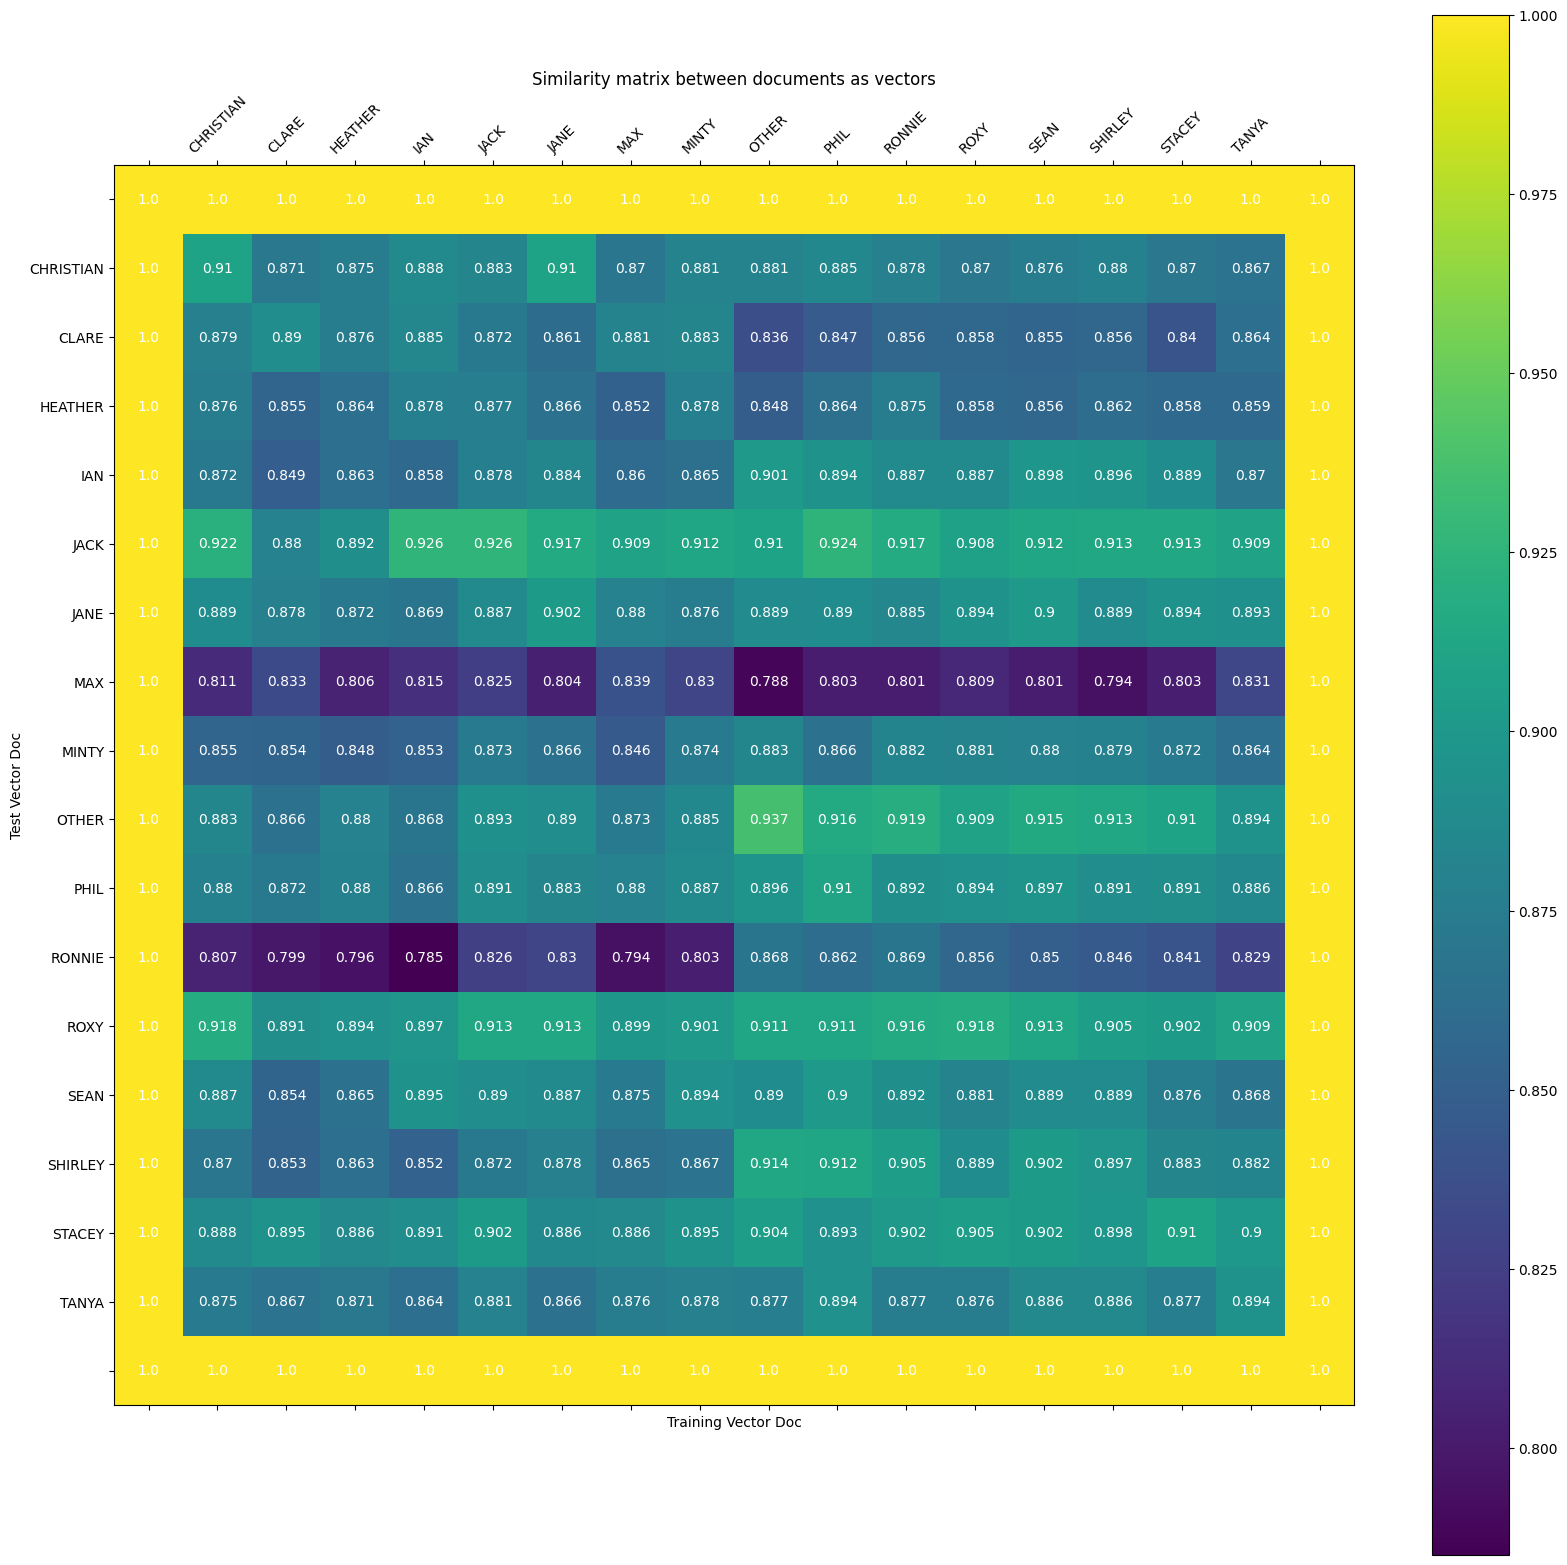

In [386]:
plot_heat_map_similarity(df)

In [387]:
# For Analysing the similarity results, Question no. 3

jack_lines = (train_character_docs['JACK'])
phil_lines = (train_character_docs['PHIL'])
confused_words = []

for i in jack_lines.split():
    if i in phil_lines.split():
        confused_words.append(i)
print(confused_words)
        
ronnie_lines = (train_character_docs['RONNIE'])
ian_lines = (train_character_docs['IAN'])
similar_words = []


for i in ronnie_lines.split():
    if i in ian_lines.split():
        similar_words.append(i)
print(similar_words)

    

['Where', 'have', 'you', 'been?', 'What', 'were', 'the', 'about?', '_EOL_', 'Well', "I've", 'got', 'here', 'I', 'wanted', 'to', 'have', 'a', 'with', "I've", 'been', 'serving', 'the', '_EOL_', "It's", 'on', 'the', 'house.', 'Are', 'you', 'alright?', '_EOL_', 'I', 'the', 'night', 'at', 'home.', "I'm", 'gonna', 'be', 'about', '_EOL_', 'Are', 'you', 'alright?', "You've", 'been', 'a', 'bit', 'off', 'you', 'got', 'here.', '_EOL_', 'So', "that's", 'why', 'you', 'were', 'You', 'had', 'a', 'little', 'set', 'up', '_EOL_', 'Well,', 'how', 'about', 'I', 'you', 'a', 'of', 'this', 'and', 'take', 'you', 'what', 'So,', 'I', 'you', 'Then', 'what?', '_EOL_', 'And', 'then?', '_EOL_', 'I', 'think', 'we', 'have', 'a', 'laugh', 'and', 'then', 'that', 'would', '_EOL_', 'The', 'where', "we're", 'too', 'for', 'it', 'to', 'be', 'friends.', 'The', 'one', 'where', 'I', 'can', 'the', 'on', 'your', 'and', 'I', 'wonder', 'who', 'is', 'enough', 'to', '...', '_EOL_', '_EOL_', 'not', 'Go', 'to', 'one', 'of', 'them.', '

["I'll", 'be', 'with', 'you', 'in', 'two', 'yeah?', '_EOL_', 'Two', '_EOL_', 'Okay.', '_EOL_', 'little', "aren't", 'you?', '_EOL_', "I'd", 'have', 'it.', '_EOL_', "I'm", 'doing', 'all', 'the', 'work', 'here', 'that', "doesn't", '_EOL_', 'What', 'that', 'then?', '_EOL_', 'What', 'the', 'is', 'going', 'on', 'here?', '_EOL_', 'you', 'have', 'been', 'for', 'this', 'all', 'night.', 'now.', '_EOL_', '_EOL_', 'not.', "I'm", 'sorry', 'about', '_EOL_', 'I', 'think', "I've", 'got', 'someone', 'in', 'line', '_EOL_', "He'll", '_EOL_', 'best', 'yet.', '_EOL_', 'I', '_EOL_', 'You', 'know', 'a', 'better', '_EOL_', 'And', 'that?', '_EOL_', 'the', 'a', '_EOL_', 'I', 'you', "didn't", 'have', '_EOL_', 'you', 'Take', 'a', 'look', 'at', 'me.', 'You', 'think', "it's", 'a', 'good', '_EOL_', "I'm", 'fine.', '_EOL_', "That's", 'right.', 'I', 'said', "I'd", 'go', 'over.', '_EOL_', 'What?', '_EOL_', "you'll", 'have', 'to', 'go.', '_EOL_', 'Your', 'Your', 'bad.', '_EOL_', 'well', 'as', 'can', 'be', '_EOL_', 'Aunt

In [388]:
print(f"Length of confused words between Jack and Phil: {len(confused_words)}")

print(f"Length of confused words between Ronnie and Ian: {len(similar_words)}")

Length of confused words between Jack and Phil: 3338
Length of confused words between Ronnie and Ian: 2578


# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set and a mean rank of **4.5** and accuracy of **0.25** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


# Q2. Improve linguistic feature extraction (20 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

You could use feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

# Q3. Analyse the similarity results (10 marks)
From your system so far run on the 90%/10% training/validation split, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

# Q4. Add dialogue context and scene features (20 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. You can also use **scene_info** column to extract information about the scene **(but DO NOT USE the GENDER and CHARACTER columns directly)**.

# Q5. Improve the vectorization method (20 marks)
Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [ ]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)